## State Space Models 

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

2024-02-01 17:40:36.698683: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tfd = tfp.distributions
tfb = tfp.bijectors
root = tfd.JointDistributionCoroutine.Root

#### Create Data

In [46]:
theta0, theta1 = 1.2, 2.6
sigma = 0.4
num_timesteps = 100

time_stamp = tf.linspace(0., 1., num_timesteps)[..., None]
yhat = theta0 + theta1 * time_stamp
y = tfd.Normal(yhat, sigma).sample()

#### LGSSM - Linear Gaussian State Space Model 

In [47]:
# create initial state matrix X_0
initial_state_prior = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[5., 5.])

# create the transition matrix F_t to transition from X_t to X_t+1
transition_matrix = lambda _: tf.linalg.LinearOperatorIdentity(2)

# create the noise matrix eta_t = N(0, Q_t)
transition_noise = lambda _: tfd.MultivariateNormalDiag(loc= [0., 0.], scale_diag=[0., 0.])

# create the observation matrix H_t to transition from X_t to Y_t
H = tf.concat([tf.ones_like(time_stamp), time_stamp], axis=-1)
observation_matrix = lambda t: tf.linalg.LinearOperatorFullMatrix([tf.gather(H, t)])

# create ovservation noise epsilon_t = N(0, R_t)
observation_noise = lambda _: tfd.MultivariateNormalDiag(loc= [0.], scale_diag= [sigma])

# create the linear growth model LGSSM
linear_growth_model = tfd.LinearGaussianStateSpaceModel(
    num_timesteps=num_timesteps,
    transition_matrix=transition_matrix,
    transition_noise=transition_noise,
    observation_matrix=observation_matrix,
    observation_noise=observation_noise,
    initial_state_prior=initial_state_prior
)

In [48]:
%%time
# run kalman filter
(log_likelihoods,
    mt_filtered, mt_predicted,
    Pt_filtered, Pt_predicted, 
    observation_means, observation_cov # observation_cov is covariance matrix of observation noise S_t
    ) = linear_growth_model.forward_filter(y)

CPU times: user 2.89 s, sys: 23 ms, total: 2.92 s
Wall time: 2.95 s


In [49]:
m0 = initial_state_prior.mean()
P0 = initial_state_prior.covariance()

P0_inv = tf.linalg.inv(P0)
P_t = tf.linalg.inv(P0_inv + 
                    1 / sigma **2 * (tf.matmul(H, H, transpose_a=True)))
m_t = tf.matmul(P_t, (1 / sigma **2 * (tf.matmul(H, y, transpose_a=True)) + 
                      tf.matmul(P0_inv, m0[..., None])))
filtered_vars = tf.linalg.diag_part(Pt_filtered)

In [75]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Create subplots
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.05)

# Plot observed time series
fig.add_trace(go.Scatter(x=time_stamp.numpy().flatten(), y=y.numpy().flatten(), mode='markers', name='Observed', marker=dict(symbol='circle-open', size=8, color='rgba(0, 0, 0, 0.5)')), row=1, col=1)
fig.add_trace(go.Scatter(x=time_stamp.numpy().flatten(), y=observation_means.numpy().flatten(), mode='lines', name='Predicted', line=dict(width=1.5, color='black')), row=1, col=1)

# Plot theta0
fig.add_trace(go.Scatter(x=time_stamp.numpy().flatten(), y=mt_filtered[..., 0].numpy().flatten(), mode='lines', name='theta0', line=dict(color='rgba(204, 0, 0, 1)')), row=2, col=1)

# Plot theta1
fig.add_trace(go.Scatter(x=time_stamp.numpy().flatten(), y=mt_filtered[..., 1].numpy().flatten(), mode='lines', name='theta1', line=dict(color='rgba(0, 102, 204, 1)')), row=3, col=1)

# Plot diag(P_t)
fig.add_trace(go.Scatter(x=time_stamp.numpy().flatten(), y=tf.linalg.diag_part(P_t).numpy().flatten(), mode='lines', name='diag(P_t)', line=dict(color='rgba(0, 0, 0, 0.5)')), row=3, col=1)

# Add horizontal lines for m_t
fig.add_shape(type='line', x0=time_stamp[0].numpy(), y0=m_t[0].numpy(), x1=time_stamp[-1].numpy(), y1=m_t[0].numpy(), line=dict(color='rgba(204, 0, 0, 0.5)', dash='dash'), row=2, col=1)
fig.add_shape(type='line', x0=time_stamp[0].numpy(), y0=m_t[1].numpy(), x1=time_stamp[-1].numpy(), y1=m_t[1].numpy(), line=dict(color='rgba(0, 102, 204, 0.5)', dash='dash'), row=3, col=1)

# Set layout
fig.update_layout(
 title='Linear Growth LGSSM',
 xaxis_title='Time',
 showlegend=True,
 legend=dict(x=0, y=1),
 width=800,
 height=800,
 margin=dict(l=50, r=50, t=50, b=50),
 template='plotly_white'
)

fig.show()

#### Create ARMA as LGSSM

In [94]:
num_timesteps = 300
phi1 = -0.1
phi2 = 0.5
theta1 = -0.25
sigma = 1.25

# create initial state matrix X_0
initial_state_prior = tfd.MultivariateNormalDiag(scale_diag = [sigma, sigma])

# create transition matrix F_t to transition from X_t to X_t+1
transition_matrix = lambda _: tf.linalg.LinearOperatorFullMatrix([[phi1, 1], [phi2, 0]])

# create noise matrix eta_t = N(0, Q_t)
R_t = tf.constant([[sigma], [sigma*theta1]])
Q_t_tril = tf.concat([R_t, tf.zeros_like(R_t)], axis=-1)
transition_noise = lambda _: tfd.MultivariateNormalTriL(scale_tril=Q_t_tril)

# create observation matrix H_t to transition from X_t to Y_t
observation_matrix = lambda t: tf.linalg.LinearOperatorFullMatrix([[1., 0.]])

# create observation noise epsilon_t = N(0, 0)
observation_noise = lambda _: tfd.MultivariateNormalDiag(loc= [0.], scale_diag= [0.])

arma = tfd.LinearGaussianStateSpaceModel(
   num_timesteps = num_timesteps,
   transition_matrix = transition_matrix,
   transition_noise = transition_noise,
   observation_matrix = observation_matrix,
   observation_noise = observation_noise,
   initial_state_prior = initial_state_prior
)

In [79]:
%%time
# simulate from the model
sim_ts = arma.sample()

CPU times: user 12.2 s, sys: 71.8 ms, total: 12.2 s
Wall time: 12.3 s


In [82]:
# check if simulated data is konvex (Q_t is positive semi-definite)
np.linalg.eigvals(Q_t_tril @ tf.transpose(Q_t_tril)) >= 0

array([ True,  True])

<tf.Tensor: shape=(), dtype=float32, numpy=-481.8804>

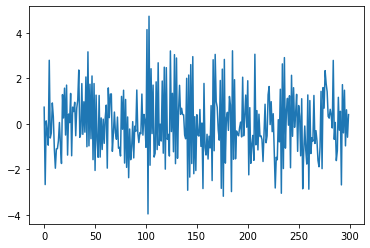

In [85]:
plt.plot(sim_ts)
arma.log_prob(sim_ts)

In [90]:
# a NUTS sampling routine with simple tuning
from tensorflow_probability.python.internal import unnest
from tensorflow_probability.python.internal import samplers


def run_mcmc_simple(
    n_draws,
    joint_dist,
    n_chains=4,
    num_adaptation_steps=1000,
    return_compiled_function=False,
    target_log_prob_fn=None,
    bijector=None,
    init_state=None,
    seed=None,
    **pins):
    joint_dist_pinned = joint_dist.experimental_pin(**pins) if pins else joint_dist
    if bijector is None:
        bijector = joint_dist_pinned.experimental_default_event_space_bijector()
    if target_log_prob_fn is None:
        target_log_prob_fn = joint_dist_pinned.unnormalized_log_prob

    if seed is None:
        seed = 26401
    run_mcmc_seed = samplers.sanitize_seed(seed, salt='run_mcmc_seed')

    if init_state is None:
        if pins:
            init_state_ = joint_dist_pinned.sample_unpinned(n_chains)
        else:
            init_state_ = joint_dist_pinned.sample(n_chains)
        ini_state_unbound = bijector.inverse(init_state_)
        run_mcmc_seed, *init_seed = samplers.split_seed(
            run_mcmc_seed, n=len(ini_state_unbound)+1)
        init_state = bijector.forward(
            tf.nest.map_structure(
                lambda x, seed: tfd.Uniform(-1., tf.constant(1., x.dtype)).sample(
                    x.shape, seed=seed),
                ini_state_unbound,
                tf.nest.pack_sequence_as(ini_state_unbound, init_seed)))

    @tf.function(autograph=False, jit_compile=True)
    def run_inference_nuts(init_state, draws, tune, seed):
        seed, tuning_seed, sample_seed = samplers.split_seed(seed, n=3)

        def gen_kernel(step_size):
            hmc = tfp.mcmc.NoUTurnSampler(
                target_log_prob_fn=target_log_prob_fn, step_size=step_size)
            hmc = tfp.mcmc.TransformedTransitionKernel(
                hmc, bijector=bijector)
            tuning_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
                hmc, tune // 2, target_accept_prob=0.85)
            return tuning_hmc

        def tuning_trace_fn(_, pkr):
            return pkr.inner_results.transformed_state, pkr.new_step_size

        def get_tuned_stepsize(samples, step_size):
            return tf.math.reduce_std(samples, axis=0) * step_size[-1]

        step_size = tf.nest.map_structure(
            tf.ones_like, bijector.inverse(init_state))
        tuning_hmc = gen_kernel(step_size)
        init_samples, (sample_unbounded, tuning_step_size) = tfp.mcmc.sample_chain(
            num_results=200,
            num_burnin_steps=tune // 2 - 200,
            current_state=init_state,
            kernel=tuning_hmc,
            trace_fn=tuning_trace_fn,
            seed=tuning_seed)

        tuning_step_size = tf.nest.pack_sequence_as(
            sample_unbounded, tuning_step_size)
        step_size_new = tf.nest.map_structure(get_tuned_stepsize,
                                              sample_unbounded,
                                              tuning_step_size)
        sample_hmc = gen_kernel(step_size_new)

        def sample_trace_fn(_, pkr):
            energy_diff = unnest.get_innermost(pkr, 'log_accept_ratio')
            return {
                'target_log_prob': unnest.get_innermost(pkr, 'target_log_prob'),
                'n_steps': unnest.get_innermost(pkr, 'leapfrogs_taken'),
                'diverging': unnest.get_innermost(pkr, 'has_divergence'),
                'energy': unnest.get_innermost(pkr, 'energy'),
                'accept_ratio': tf.minimum(1., tf.exp(energy_diff)),
                'reach_max_depth': unnest.get_innermost(pkr, 'reach_max_depth'),
            }
        current_state = tf.nest.map_structure(lambda x: x[-1], init_samples)
        return tfp.mcmc.sample_chain(
            num_results=draws,
            num_burnin_steps=tune // 2,
            current_state=current_state,
            kernel=sample_hmc,
            trace_fn=sample_trace_fn,
            seed=sample_seed)

    mcmc_samples, mcmc_diagnostic = run_inference_nuts(
        init_state, n_draws, num_adaptation_steps, run_mcmc_seed)

    if return_compiled_function:
        return mcmc_samples, mcmc_diagnostic, run_inference_nuts
    else:
        return mcmc_samples, mcmc_diagnostic

In [99]:
@tfd.JointDistributionCoroutine
def arma_lgssm():
    sigma = yield root(tfd.HalfStudentT(df=7, loc=0, scale=1., name='sigma'))
    phi = yield root(tfd.Sample(tfd.Normal(loc=0, scale=0.5), 2, name='phi'))
    theta = yield root(tfd.Sample(tfd.Normal(loc=0, scale=0.5), 1, name='theta'))

    # X0
    init_scale_diag = tf.concat([sigma[..., None], sigma[..., None]], axis=-1)
    initial_state_prior = tfd.MultivariateNormalDiag(
        scale_diag=init_scale_diag)

    F_t = tf.concat([phi[..., None],
                     tf.concat([tf.ones_like(phi[..., 0, None]),
                                tf.zeros_like(phi[..., 0, None])],
                               axis=-1)[..., None]],
                    axis=-1)

    def transition_matrix(_): return tf.linalg.LinearOperatorFullMatrix(F_t)

    transition_scale_tril = tf.concat(
        [sigma[..., None], theta * sigma[..., None]], axis=-1)[..., None]
    scale_tril = tf.concat(
        [transition_scale_tril,
         tf.zeros_like(transition_scale_tril)],
        axis=-1)

    def transition_noise(_): return tfd.MultivariateNormalTriL(
        scale_tril=scale_tril)

    def observation_matrix(
        t): return tf.linalg.LinearOperatorFullMatrix([[1., 0.]])

    def observation_noise(t): return tfd.MultivariateNormalDiag(
        loc=[0], scale_diag=[0.])

    arma = yield tfd.LinearGaussianStateSpaceModel(
        num_timesteps=num_timesteps,
        transition_matrix=transition_matrix,
        transition_noise=transition_noise,
        observation_matrix=observation_matrix,
        observation_noise=observation_noise,
        initial_state_prior=initial_state_prior,
        name='arma')

In [100]:
%%time
mcmc_samples, sampler_stats = run_mcmc_simple(
    1000, arma_lgssm, n_chains=4, num_adaptation_steps=1000,
    seed=tf.constant([23453, 94567], dtype=tf.int32),
    arma=sim_ts)

I0000 00:00:1706811271.987328       1 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-02-01 19:14:32.260728: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


CPU times: user 48.2 s, sys: 1.06 s, total: 49.3 s
Wall time: 50.8 s


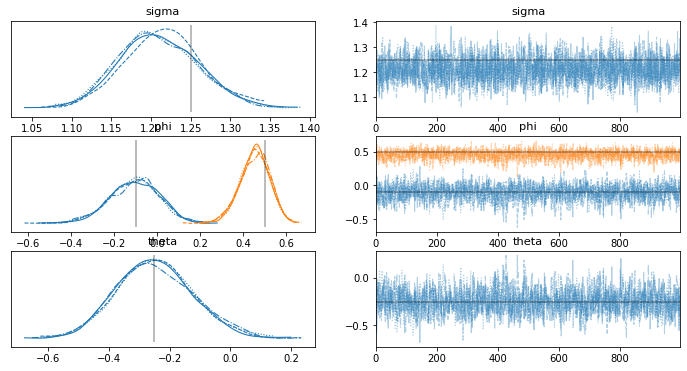

In [101]:
test_trace = az.from_dict(
    posterior={
        k:np.swapaxes(v.numpy(), 1, 0)
        for k, v in mcmc_samples._asdict().items()},
    sample_stats={
        k:np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]}
)

lines = (('sigma', {}, sigma), ('phi', {}, [phi1, phi2]), ('theta', {}, theta1),)
axes = az.plot_trace(test_trace, lines=lines);